# Sentiment Analysis

In [65]:
from __future__ import print_function
%matplotlib inline

from IPython.display import Image, display
from io import BytesIO
import matplotlib.pyplot as plt

#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer

#import numpy as numpy
import random
#import pickle
from collections import Counter
import codecs
import tensorflow as tf
import np
import time

import os
from os.path import join, exists

import pandas as pd
import pydot_ng as pydot
import graphviz
from ggplot import *

from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten, LSTM
from keras.optimizers import RMSprop, Adam, SGD, Adagrad

#nltk.download('punkt')
#nltk.download('wordnet')
#totalLinesToRead = 100
#lemmatizer = WordNetLemmatizer()

# Data load

The first step when building machine learning model is getting your data into the proper form to feed into the model. 


In [66]:
with open('./data/comedy-train-fun', 'r') as f:
    positive_train_txt = f.read()
with open('./data/comedy-train-notfun', 'r') as f:
    negative_train_txt = f.read()

In [67]:
print("The positive data size: {}".format(len(positive_train_txt)))
print("The negative data size: {}".format(len(negative_train_txt)))

The positive data size: 1085994
The negative data size: 1540229


## Basic prediction
Let's assume we will say to all data positive.


In [68]:
print("Basic/Benchmark Accuracy: " + str(float(len(positive_train_txt)) / (len(positive_train_txt) + len(negative_train_txt))))

Basic/Benchmark Accuracy: 0.413519339371


# Download GloVe


In [69]:
data_folder = './datasets'
glove = 'glove.6B'
glove_filename = glove + '.zip'
glove_url = 'http://nlp.stanford.edu/data/' + glove_filename
embedding_dim = 300
glove_loc = join(data_folder, glove_filename)

if not exists(glove_loc):
    print('Download %s' % glove_filename)
    get_file(glove_filename, glove_url, cache_dir='.', extract=True)

glove_filename = os.path.join(data_folder, glove + '.' + str(embedding_dim) + 'd.txt')

embeddings = {}

print('Extract %s' % glove_filename)
with open(glove_filename, 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings[word] = embedding
        
print('Embeddings size: %d' % len(embeddings))

Extract ./datasets/glove.6B.300d.txt
Embeddings size: 400000


# Data preprocessing

First, let's remove all punctuation. Then get all the text without the newlines and split it into individual words.

In [70]:
from string import punctuation

def get_reviews(text):
    #all_text = ''.join([c for c in text if c not in punctuation])
    reviews = text.split('\n')
    return reviews # TAKE first 1000 to make it fast

positive_train = get_reviews(positive_train_txt)
negative_train = get_reviews(negative_train_txt)

positive_label = np.full((len(positive_train), 2), [1, 0])
negative_label = np.full((len(negative_train), 2), [0, 1])

train = np.concatenate((positive_train, negative_train), axis=0)
labels = np.concatenate((positive_label, negative_label), axis=0)

# shuffle
c = np.c_[train.reshape(len(train), -1), labels.reshape(len(labels), -1)]
np.random.shuffle(c)

train = c[:, :train.size//len(train)].reshape(train.shape)
labels = c[:, train.size//len(train):].reshape(labels.shape)

del c
del positive_label
del negative_label

print("Train shape: \t\t{}".format(train.shape))
print("Label shape: \t\t{}".format(labels.shape))

Train shape: 		(11636,)
Label shape: 		(11636, 2)


## Encoding the words
Create dictinaries that map the words in the vocaulary to integers. Then we can convert each of our reviews into integers sos they can be passed into the network.

In [71]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)
train_ints = tokenizer.texts_to_sequences(train)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 31697 unique tokens.


In [72]:
#word_index['dog']
#embeddings['dog']

#embedding_vector[876]
#[-1.1043e-01,  8
 
#print(tokenizer.texts_to_sequences("once upon a time once"))
#train

## Prepare Word Embeddings

In [73]:
from collections import defaultdict
NUM_WORDS = len(embeddings)
words_len = min(NUM_WORDS, len(word_index))
word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
k = 0
for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        k += 1
        
del embeddings

In [74]:
print('Null word embeddings: %d' % (np.sum(np.sum(word_embedding_matrix, axis=1) == 0) - 1))
print('Found %d' % k)
print('Total: %d' % len(word_embedding_matrix))

Null word embeddings: -1
Found 25316
Total: 31698


## Sentence length

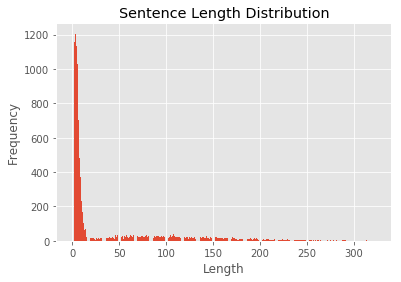

In [75]:
from collections import defaultdict

max_word_count_text = 0
text_count = defaultdict(int)
for sentence in train_ints:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1
    
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())

plt.title("Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [76]:
print('Max word sentence: %d' % max_word_count_text)

Max word sentence: 1083


Some issues here. We seem to have one data with zero length. And, the maximum data length is way too many steps for our RNN. Let's truncate to 50 steps. For data shorter than 50, we'll pad with 0s. For data longer than 50, we can truncate them to the first 50 characters.

Turns out its the final review that has zero length. But that might not always be the case, so let's make it more general.


In [77]:
#train_ints = [train_ints[ii] for ii in non_zero_idx]
#labels = np.array([labels[ii] for ii in non_zero_idx])

Now, create an array features that contains the data we'll pass to the network. The data should come from review_ints, since we want to feed integers to the network. Each row should be 50 elements long. For data shorter than 50 words, left pad with 0s. For reviews longer than 50, use on the first 50 words as the feature vector.

In [78]:
seq_len = 50
features = sequence.pad_sequences(train_ints, maxlen = seq_len)

In [79]:

print('One sample')

print('Text: ')
print( train[1] )

print('Word sequence: ')
print( train_ints[1] )

print('Pad: ')
print( features[1] )

print('Label: ')
print( labels[1] )

del train

One sample
Text: 
ICE HOCKEY - BEST OF (REMI GAILLARD); Oh Oh; 
Word sequence: 
[529, 3005, 160, 7, 4723, 4282, 21, 21]
Pad: 
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0  529 3005  160
    7 4723 4282   21   21]
Label: 
['1' '0']


# Training, Validation, Test

With our data in nice shape, we'll split it into training, validation, and test sets. Do not foget to shuffle it.

In [80]:
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape)) 
print("Validation set: \t{}".format(val_x.shape))
print("Test set: \t\t{}".format(test_x.shape))

print("Train lable: \t\t{}".format(train_y.shape))


			Feature Shapes:
Train set: 		(9308, 50)
Validation set: 	(1164, 50)
Test set: 		(1164, 50)
Train lable: 		(9308, 2)


## Create Sentiment Neural Network

In [81]:
def createModel(hidden_size, drop_size, output_activation):
    model = Sequential()

    model.add(Dense(hidden_size, activation='relu', input_dim = seq_len))
    
    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu'))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu'))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(2, activation=output_activation))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model




In [82]:
def createEmbeddedModel(hidden_size, drop_size):
    model = Sequential()
    
    model.add(Embedding(words_len + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = seq_len,
                     trainable = False,
                     name = 'embedding'))
    if drop_size > 0.0:
        model.add(Dropout(drop_size))
        
    model.add(LSTM(seq_len, dropout=0.2, recurrent_dropout=0.2))
    
    model.add(Dense(hidden_size, activation='relu', input_dim = seq_len, name="hidden_1"))
    
    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu', name="hidden_2"))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu', name="hidden_3"))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))
        
    #model.add(Flatten())  # [[ [1, 2], [2, 2] ], ....]  -> [[ 1, 2, 2, 2], ....]

    model.add(Dense(2, activation='softmax', name="output"))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model

## Train model

In [83]:
batch_size = 20
epochs = 5

# 16000 -> 100, 100, 100

models = {}

#models['model_200_drop_0.1_softmax'] = createModel(200, 0.1, 'softmax')
#models['model_200_drop_0.1_sigmoid'] = createModel(200, 0.1, 'sigmoid')

#models['model_400_drop_0.1'] = createModel(400, 0.1)
#models['model_600_drop_0.1'] = createModel(600, 0.1)
#models['model_200_no_drop'] = createModel(200, 0)
#models['model_400_no_drop'] = createModel(400, 0)
#models['model_600_no_drop'] = createModel(600, 0)

models['model_200_embedded_drop_0_comedy_ALL'] = createEmbeddedModel(200, 0)

results = []
for name, model in models.items():  
    start_time = time.time()
    print('')
    print('Start learning %s at %d' % (name, start_time))
    print('Epochs: %d' % epochs)
    print('Batch size: %d' % batch_size)

    history = model.fit(train_x, train_y,
              batch_size = batch_size,
              epochs = epochs,
              validation_data=(val_x, val_y))

    end_time = time.time()
    average_time_per_epoch = (end_time - start_time) / epochs
    results.append((history, average_time_per_epoch))
    print('Time: %d' % (end_time - start_time))


Start learning model_200_embedded_drop_0_comedy_ALL at 1521772475
Epochs: 5
Batch size: 20
Train on 9308 samples, validate on 1164 samples
Epoch 1/5
9308/9308 [==============================] - 42s 4ms/step - loss: 0.6746 - acc: 0.6003 - val_loss: 0.6826 - val_acc: 0.5825
Epoch 2/5
9308/9308 [==============================] - 46s 5ms/step - loss: 0.6682 - acc: 0.6012 - val_loss: 0.6774 - val_acc: 0.5782
Epoch 3/5
9308/9308 [==============================] - 61s 7ms/step - loss: 0.6604 - acc: 0.6094 - val_loss: 0.6792 - val_acc: 0.5773
Epoch 4/5
9308/9308 [==============================] - 41s 4ms/step - loss: 0.6458 - acc: 0.6274 - val_loss: 0.6854 - val_acc: 0.5739
Epoch 5/5
9308/9308 [==============================] - 39s 4ms/step - loss: 0.6265 - acc: 0.6414 - val_loss: 0.7311 - val_acc: 0.5679
Time: 229


In [84]:
model.save('model_50_embedded_drop_0_comedy.h5')

In [85]:
for name, model in models.items():  
    
    score, acc = model.evaluate(test_x, test_y,
                                batch_size=batch_size)
    print('Model:', name)
    print('  Test score:', score)
    print('  Test accuracy:', acc)

1164/1164 [==============================] - 1s 1ms/step
Model: model_200_embedded_drop_0_comedy_ALL
  Test score: 0.718810841185
  Test accuracy: 0.560137457659


# Training Results

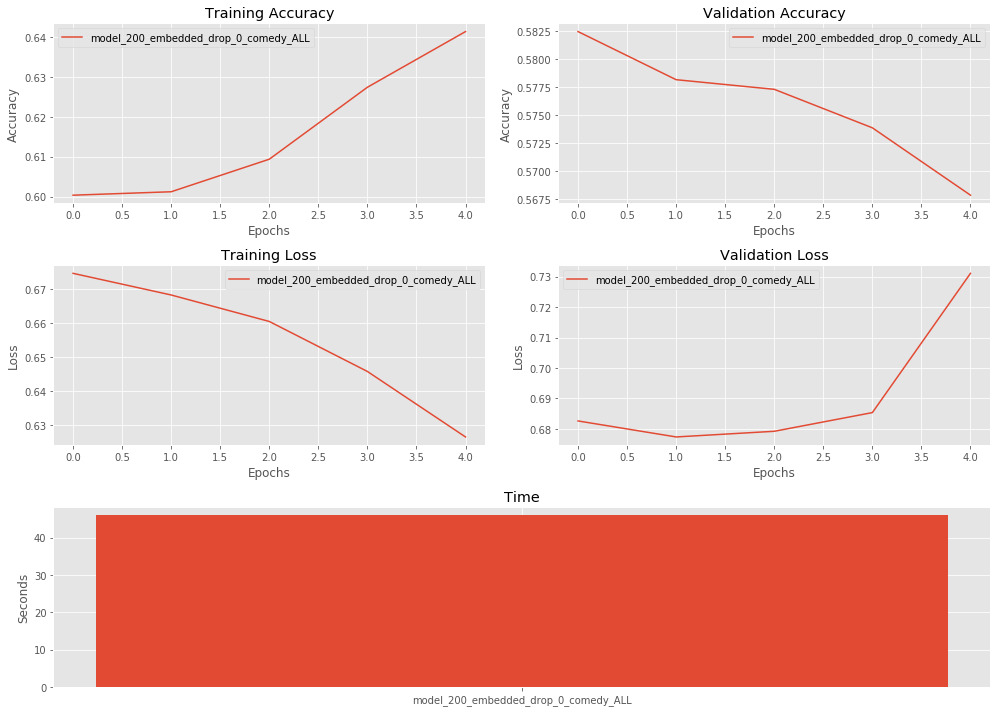

In [86]:

plt.style.use('ggplot')
plt.figure(figsize=(14, 10))#, dpi=100)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.set_title('Training Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.set_title('Training Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax3 = plt.subplot2grid((3, 2), (0, 1))
ax3.set_title('Validation Accuracy')
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Epochs')

ax4 = plt.subplot2grid((3, 2), (1, 1))
ax4.set_title('Validation Loss')
ax4.set_ylabel('Loss')
ax4.set_xlabel('Epochs')

ax5 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=2)
ax5.set_title('Time')
ax5.set_ylabel('Seconds')

for mode, result in zip(models, results):
    ax1.plot(result[0].epoch, result[0].history['acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['loss'], label=mode)
    ax3.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax4.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
    
ax1.legend()
ax2.legend()

ax3.legend()
ax4.legend()

ax5.bar(np.arange(len(results)), [x[1] for x in results], tick_label = models.keys(), align='center')

plt.tight_layout()
plt.show()

In [87]:
for name, model in models.items():
    classes = model.predict(test_x, batch_size=20)
    
print(classes)

[[ 0.21681964  0.78318036]
 [ 0.60903758  0.39096245]
 [ 0.24809863  0.75190139]
 ..., 
 [ 0.45516986  0.5448302 ]
 [ 0.00702129  0.99297875]
 [ 0.31149203  0.68850797]]


In [88]:
predicted = np.argmax(classes, axis=1)
real = np.argmax(test_y, axis=1)

#print(predicted)
#print(real)

pos = 0
neg = 0

for i in xrange(len(predicted)):
    if predicted[i] == real[i]:
        if predicted[i] == 1:
            pos += 1
        else:
            neg += 1
            
print("funny matched " + str(pos))
print("not funny matched " + str(neg))

#(predicted == real).all()

len(classes)

total_pos = 0
total_neg = 0

for i in xrange(len(predicted)):
    if predicted[i] == 1:
        total_pos += 1
    else:
        total_neg += 1
        
print("funny total " + str(total_pos))
print("not funny total " + str(total_neg))

funny matched 546
not funny matched 106
funny total 910
not funny total 254


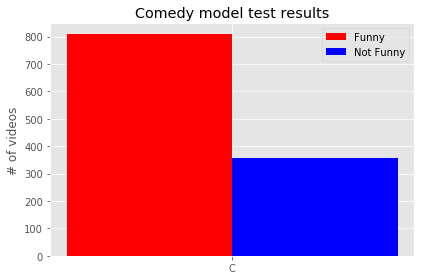

In [ ]:
import np
import matplotlib.pyplot as plt

N = 1
total_funny = (808)
#men_std = (2, 3)

ind = np.arange(N)  # the x locations for the groups
width = 0.15       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, total_funny, width, color='r', yerr=0)

total_not_funny = (356)
#women_std = (3, 5)
rects2 = ax.bar(ind + width, total_not_funny, width, color='b', yerr=0)

# add some text for labels, title and axes ticks
ax.set_ylabel('# of videos')
ax.set_title('Comedy model test results')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Comedy'))

ax.legend((rects1[0], rects2[0]), ('Funny', 'Not Funny'))

plt.tight_layout()

plt.show()

#plt.savefig('comedyplot.png')

# Applying Sentiment Models to this Test Set

## Twitter

In [ ]:
from keras.models import load_model

twitter_model = load_model('model_15_embedded_drop_0.1_twitter.h5')
twitter_classes = twitter_model.predict(test_x, batch_size=20)
print(twitter_classes)

In [ ]:
comedy_model_15 = load_model('model_15_embedded_drop_0_comedy.h5')
comedy_classes_15 = comedy_model_15.predict(test_x, batch_size=20)
print(comedy_classes_15)

In [ ]:
twitter_predicted = np.argmax(twitter_classes, axis=1)

tw_total_pos = 0
tw_total_neg = 0

for i in xrange(len(twitter_predicted)):
    if twitter_predicted[i] == 1:
        tw_total_pos += 1
    else:
        tw_total_neg += 1
        
print("positive total " + str(tw_total_pos))
print("negative total " + str(tw_total_neg))

In [ ]:
comedy_predicted = np.argmax(comedy_classes_15, axis=1)

tw_com_pf = 0
tw_com_nf = 0
tw_com_pnf = 0
tw_com_nnf = 0

for i in xrange(len(twitter_predicted)):
    if twitter_predicted[i] == 1 and comedy_predicted[i] == 1:
        tw_com_pf += 1
    elif twitter_predicted[i] == 1 and comedy_predicted[i] == 0:
        tw_com_pnf += 1
    elif twitter_predicted[i] == 0 and comedy_predicted[i] == 1:
        tw_com_nf += 1
    elif twitter_predicted[i] == 0 and comedy_predicted[i] == 0:
        tw_com_nnf += 1
        
print("positive funny " + str(tw_com_pf))
print("negative funny " + str(tw_com_nf))
print("positive not funny " + str(tw_com_pnf))
print("negative not funny " + str(tw_com_nnf))

In [ ]:
import np
import matplotlib.pyplot as plt

N = 2
pos = (405, 135)
#men_std = (2, 3)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, pos, width, color='r', yerr=0)

neg = (465, 159)
#women_std = (3, 5)
rects2 = ax.bar(ind + width, neg, width, color='b', yerr=0)

# add some text for labels, title and axes ticks
ax.set_ylabel('# of videos')
ax.set_title('Comedy + Twitter test results')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('F', 'N'))

ax.legend((rects1[0], rects2[0]), ('Positive', 'Negative'))

plt.tight_layout()

plt.show()

plt.savefig('comedy_twitter_plot.png')

# Netflix

In [ ]:
netflix_model = load_model('model_100_embedded_drop_0_netflix_ALL.h5')
netflix_classes = netflix_model.predict(test_x, batch_size=20)
print(netflix_classes)

In [ ]:
netflix_predicted = np.argmax(netflix_classes, axis=1)

nx_total_pos = 0
nx_total_neg = 0

for i in xrange(len(netflix_predicted)):
    if netflix_predicted[i] == 1:
        nx_total_pos += 1
    else:
        nx_total_neg += 1
        
print("positive total " + str(nx_total_pos))
print("negative total " + str(nx_total_neg))

In [ ]:
comedy_model_100 = load_model('model_100_embedded_drop_0_comedy.h5')
comedy_classes_100 = comedy_model_100.predict(test_x, batch_size=20)
print(comedy_classes_100)

In [ ]:
comedy_predicted = np.argmax(comedy_classes_100, axis=1)

nx_com_pf = 0
nx_com_nf = 0
nx_com_pnf = 0
nx_com_nnf = 0

for i in xrange(len(netflix_predicted)):
    if netflix_predicted[i] == 1 and comedy_predicted[i] == 1:
        nx_com_pf += 1
    elif netflix_predicted[i] == 1 and comedy_predicted[i] == 0:
        nx_com_pnf += 1
    elif netflix_predicted[i] == 0 and comedy_predicted[i] == 1:
        nx_com_nf += 1
    elif netflix_predicted[i] == 0 and comedy_predicted[i] == 0:
        nx_com_nnf += 1
        
print("positive funny " + str(nx_com_pf))
print("negative funny " + str(nx_com_nf))
print("positive not funny " + str(nx_com_pnf))
print("negative not funny " + str(nx_com_nnf))

In [ ]:
import np
import matplotlib.pyplot as plt

N = 2
pos = (417, 100)
#men_std = (2, 3)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, pos, width, color='r', yerr=0)

neg = (533, 114)
#women_std = (3, 5)
rects2 = ax.bar(ind + width, neg, width, color='b', yerr=0)

# add some text for labels, title and axes ticks
ax.set_ylabel('# of videos')
ax.set_title('Comedy + Netflix test results')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('F', 'N'))

ax.legend((rects1[0], rects2[0]), ('Positive', 'Negative'))

plt.tight_layout()

plt.show()

plt.savefig('comedy_netflix_plot1.png')